In [1]:
!pip install numpy matplotlib
!pip install ipython

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
from quantum_gate_package import I, X, Y, P0, P1, H, Z,Y

# 3-Qubit Bit-Flip Code (Simulation)

We encode:

\[
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle
\quad\Rightarrow\quad
|\psi_L\rangle = \alpha|000\rangle + \beta|111\rangle
\]

Then we apply a bit-flip error \(X_i\) on one physical qubit, measure syndrome, and correct.


In [3]:
import numpy as np

def normalize(v):
    return v / np.linalg.norm(v)

def kron(*ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def basis_ket(index, n_qubits):
    """|index> for n_qubits in ordering |q_{n-1} ... q_0>"""
    dim = 2**n_qubits
    v = np.zeros(dim, dtype=complex)
    v[index] = 1.0
    return v

def encode_bitflip3(alpha, beta):
    psi_enc = np.zeros(8, dtype=complex)
    psi_enc[0] = alpha   # |000>
    psi_enc[7] = beta    # |111>
    return psi_enc

# ================================
# Apply X error on qubit i
# qubit i ∈ {0,1,2}  (q0 is rightmost)
# ================================
def X_on_qubit(i):
    # ordering: |q2 q1 q0>
    if i == 0:
        return kron(I, I, X)
    if i == 1:
        return kron(I, X, I)
    if i == 2:
        return kron(X, I, I)

def apply_bitflip_error(state, qubit_i=None):
    """
    If qubit_i is None -> no error
    else apply X on that qubit
    """
    if qubit_i is None:
        return state
    return X_on_qubit(qubit_i) @ state

Z1Z2 = kron(I, Z, Z)  # Z on q1 and q0
Z2Z3 = kron(Z, Z, I)  # Z on q2 and q1

def syndrome(state):
    """
    Returns syndrome (s1,s2) where each is ±1:
    s1 = <Z1Z2>, s2 = <Z2Z3>
    """
    s1 = np.real(np.vdot(state, Z1Z2 @ state))
    s2 = np.real(np.vdot(state, Z2Z3 @ state))
    # round to +1/-1
    s1 = 1 if s1 >= 0 else -1
    s2 = 1 if s2 >= 0 else -1
    return (s1, s2)

def correction_from_syndrome(s):
    if s == (1, 1):
        return None
    if s == (-1, 1):
        return 0
    if s == (-1, -1):
        return 1
    if s == (1, -1):
        return 2

def correct_state(state):
    s = syndrome(state)
    q = correction_from_syndrome(s)
    if q is None:
        return state, s, None
    corrected = X_on_qubit(q) @ state
    return corrected, s, q

def fidelity(psi_ref, psi_test):
    return float(np.abs(np.vdot(psi_ref, psi_test))**2)

alpha = 0.6
beta = np.sqrt(1 - alpha**2)

psi_encoded = encode_bitflip3(alpha, beta)

print("Original encoded state |psi_L> = alpha|000> + beta|111>")
print(psi_encoded)

for err in [None, 0, 1, 2]:
    noisy = apply_bitflip_error(psi_encoded, err)
    corrected, syn, qcorr = correct_state(noisy)

    F = fidelity(psi_encoded, corrected)

    print("\n----------------------------")
    print("Error applied on qubit:", err)
    print("Measured syndrome (Z1Z2, Z2Z3):", syn)
    print("Correction applied on qubit:", qcorr)
    print("Fidelity after correction:", F)

Original encoded state |psi_L> = alpha|000> + beta|111>
[0.6+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.8+0.j]

----------------------------
Error applied on qubit: None
Measured syndrome (Z1Z2, Z2Z3): (1, 1)
Correction applied on qubit: None
Fidelity after correction: 1.0

----------------------------
Error applied on qubit: 0
Measured syndrome (Z1Z2, Z2Z3): (-1, 1)
Correction applied on qubit: 0
Fidelity after correction: 1.0

----------------------------
Error applied on qubit: 1
Measured syndrome (Z1Z2, Z2Z3): (-1, -1)
Correction applied on qubit: 1
Fidelity after correction: 1.0

----------------------------
Error applied on qubit: 2
Measured syndrome (Z1Z2, Z2Z3): (1, -1)
Correction applied on qubit: 2
Fidelity after correction: 1.0


Bit-flip code does NOT detect phase-flip errors

A phase-flip is a \(Z\) error.  
We test by applying \(Z_i\) to one qubit and checking the bit-flip syndrome.

Expectation: the syndrome does NOT change → the error is not detected.

TODO:
1) Prepare encoded state psi_L
2) Apply Z on one qubit
3) Measure Z1Z2 and Z2Z3
4) Show results look like "no error"


In [4]:
import numpy as np

I = np.eye(2, dtype=complex)
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

def kron(*ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def encode_bitflip3(alpha, beta):
    psi_enc = np.zeros(8, dtype=complex)
    psi_enc[0] = alpha
    psi_enc[7] = beta
    return psi_enc

def Z_on_qubit(i):
    if i == 0:
        return kron(I, I, Z)
    if i == 1:
        return kron(I, Z, I)
    if i == 2:
        return kron(Z, I, I)

Z1Z2 = kron(I, Z, Z)   # Z(q1)Z(q0)
Z2Z3 = kron(Z, Z, I)   # Z(q2)Z(q1)

def syndrome_bitflip_code(state):
    """
    Measure expectation values of stabilizers:
    s1 = <Z1Z2>, s2 = <Z2Z3>
    output is ±1 each.
    """
    s1 = np.real(np.vdot(state, Z1Z2 @ state))
    s2 = np.real(np.vdot(state, Z2Z3 @ state))
    s1 = 1 if s1 >= 0 else -1
    s2 = 1 if s2 >= 0 else -1
    return (s1, s2)

alpha = 0.6
beta = np.sqrt(1 - alpha**2)

psi_L = encode_bitflip3(alpha, beta)

print("Original encoded state |psi_L> = alpha|000> + beta|111>")
print("Syndrome (no error):", syndrome_bitflip_code(psi_L))

for q in [0, 1, 2]:
    psi_phase_error = Z_on_qubit(q) @ psi_L
    syn = syndrome_bitflip_code(psi_phase_error)

    print("\n----------------------------")
    print(f"Applied phase-flip Z on qubit {q}")
    print("Syndrome (Z1Z2, Z2Z3):", syn)


Original encoded state |psi_L> = alpha|000> + beta|111>
Syndrome (no error): (1, 1)

----------------------------
Applied phase-flip Z on qubit 0
Syndrome (Z1Z2, Z2Z3): (1, 1)

----------------------------
Applied phase-flip Z on qubit 1
Syndrome (Z1Z2, Z2Z3): (1, 1)

----------------------------
Applied phase-flip Z on qubit 2
Syndrome (Z1Z2, Z2Z3): (1, 1)


## Fidelity comparison: No QEC vs Bit-flip QEC

No correction fidelity (worst-case):
\[
F_{\min} = 1-p
\]

With 3-qubit bit-flip code:
\[
F \ge (1-p)^3 + 3p(1-p)^2 = 1 - 3p^2 + 2p^3
\]

We simulate and plot fidelity vs \(p\).


for p in np.linspace(0,1,101):
simulate: encode -> noise -> correction -> fidelity
plot p vs fidelity
compare with (1-p) and (1 - 3p^2 + 2p^3)


p      Sim(QEC)     Theory(QEC)   NoQEC
-----------------------------------------
0.00    1.00000     1.00000     1.00000
0.10    0.99755     0.97200     0.90000
0.20    0.99153     0.89600     0.80000
0.30    0.98291     0.78400     0.70000
0.40    0.97301     0.64800     0.60000
0.50    0.96143     0.50000     0.50000


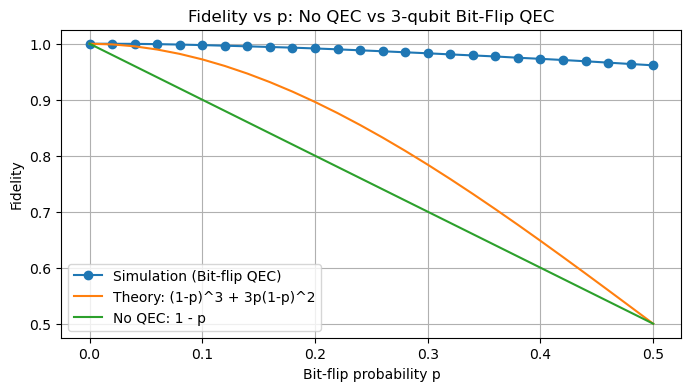

In [5]:
import matplotlib.pyplot as plt

I = np.eye(2, dtype=complex)
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

def kron(*ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def fidelity(psi_ref, psi_test):
    return float(np.abs(np.vdot(psi_ref, psi_test))**2)

def encode_bitflip3(alpha, beta):
    psi_enc = np.zeros(8, dtype=complex)
    psi_enc[0] = alpha
    psi_enc[7] = beta
    return psi_enc

def X_on_qubit(i):
    if i == 0:
        return kron(I, I, X)
    if i == 1:
        return kron(I, X, I)
    if i == 2:
        return kron(X, I, I)

Z1Z2 = kron(I, Z, Z)
Z2Z3 = kron(Z, Z, I)

def syndrome(state):
    s1 = np.real(np.vdot(state, Z1Z2 @ state))
    s2 = np.real(np.vdot(state, Z2Z3 @ state))
    s1 = 1 if s1 >= 0 else -1
    s2 = 1 if s2 >= 0 else -1
    return (s1, s2)

def correction_from_syndrome(s):
    if s == (1, 1):
        return None
    if s == (-1, 1):
        return 0
    if s == (-1, -1):
        return 1
    if s == (1, -1):
        return 2

def correct_state(state):
    s = syndrome(state)
    q = correction_from_syndrome(s)
    if q is None:
        return state
    return X_on_qubit(q) @ state

def apply_random_bitflips(state, p, rng):
    out = state.copy()
    for q in [0, 1, 2]:
        if rng.random() < p:
            out = X_on_qubit(q) @ out
    return out

def avg_fidelity_bitflip_qec(p, alpha=0.6, shots=3000, seed=0):
    rng = np.random.default_rng(seed)
    beta = np.sqrt(1 - alpha**2)

    psi_L = encode_bitflip3(alpha, beta)

    Fvals = []
    for _ in range(shots):
        noisy = apply_random_bitflips(psi_L, p, rng)
        corrected = correct_state(noisy)
        Fvals.append(fidelity(psi_L, corrected))

    return float(np.mean(Fvals))

alpha = 0.6
ps = np.linspace(0, 0.5, 26)

F_sim = np.array([avg_fidelity_bitflip_qec(p, alpha=alpha, shots=4000, seed=1) for p in ps])
F_no_qec = 1 - ps
F_theory = (1-ps)**3 + 3*ps*(1-ps)**2  # = 1 - 3p^2 + 2p^3

print("p      Sim(QEC)     Theory(QEC)   NoQEC")
print("-----------------------------------------")
for i in range(0, len(ps), 5):
    print(f"{ps[i]:.2f}    {F_sim[i]:.5f}     {F_theory[i]:.5f}     {F_no_qec[i]:.5f}")

plt.figure(figsize=(8,4))
plt.plot(ps, F_sim, marker="o", label="Simulation (Bit-flip QEC)")
plt.plot(ps, F_theory, label="Theory: (1-p)^3 + 3p(1-p)^2")
plt.plot(ps, F_no_qec, label="No QEC: 1 - p")

plt.xlabel("Bit-flip probability p")
plt.ylabel("Fidelity")
plt.title("Fidelity vs p: No QEC vs 3-qubit Bit-Flip QEC")
plt.grid(True)
plt.legend()
plt.show()
